In [5]:
!pip install boto
!pip install s3fs

  Using cached fsspec-2023.4.0-py3-none-any.whl (153 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.1/358.1 kB 5.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 22.4 MB/s eta 0:00:0000:010:01
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.11.0
    Uninstalling fsspec-2022.11.0:
      Successfully uninstalled fsspec-2022.11.0


In [6]:
import pandas as pd
import boto

# import the csv file directly from an s3 bucket
data = pd.read_csv('s3://articledatas3/simulated_data_house_price.csv', sep=';')

In [10]:
print(data.describe())
print(data.columns)

           SellPrice  SquareMeterHouse   BedRooms  BathRooms  \
count      21.000000         21.000000  21.000000  21.000000   
mean   153666.666667        166.380952   2.809524   1.476190   
std     55057.318617         68.760800   0.813575   0.679636   
min     99000.000000         80.000000   2.000000   1.000000   
25%    112000.000000        125.000000   2.000000   1.000000   
50%    143000.000000        148.000000   3.000000   1.000000   
75%    170000.000000        200.000000   3.000000   2.000000   
max    312000.000000        310.000000   4.000000   3.000000   

       SquareMeterGarden  
count          21.000000  
mean          195.238095  
std           273.360916  
min             0.000000  
25%             0.000000  
50%           100.000000  
75%           200.000000  
max          1000.000000  
Index(['SellPrice', 'SquareMeterHouse', 'BedRooms', 'BathRooms',
       'SquareMeterGarden'],
      dtype='object')


In [15]:
import statsmodels.api as sm

# Split the columns into y and X
y = data['SellPrice']
X = data[['SquareMeterHouse', 'BedRooms', 'BathRooms', 'SquareMeterGarden']]

# Define the modell
X = sm.add_constant(X)
model = sm.OLS(y, X)

# Fit the model
result = model.fit()

# Print the model summary
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              SellPrice   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     35.83
Date:                Sat, 15 Apr 2023   Prob (F-statistic):           8.48e-08
Time:                        23:58:20   Log-Likelihood:                -234.39
No. Observations:                  21   AIC:                             478.8
Df Residuals:                      16   BIC:                             484.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.367e+04   1.86e+0

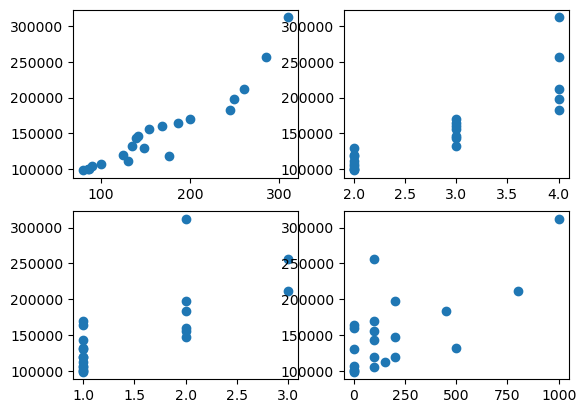

In [16]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.scatter(X['SquareMeterHouse'], y)
ax2.scatter(X['BedRooms'], y)
ax3.scatter(X['BathRooms'], y)
ax4.scatter(X['SquareMeterGarden'], y)
plt.show()

What you need to look at in QQ Plots is whether the points are on the straight line going from bottom left to top right. When deviations occur, they are often located at the lower or higher end of the line, whereas deviations in the middle are less likely.

If you see any type of an S form, an exponential curve, or another shape than a straight line, this means you have a problem: your model is probably not correctly specified. Probably you are missing some variables, or maybe your relationships are not actually linear! You may want to try out nonlinear models or other specifications of the linear model (using different variables or different preparation of the variables).

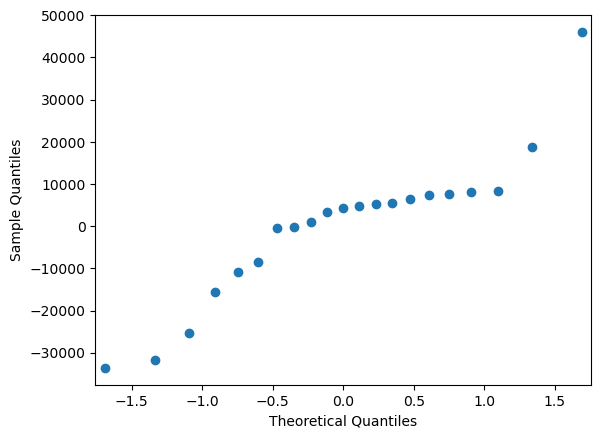

In [17]:
residuals = result.resid
sm.qqplot(residuals)
plt.show()

VIF starts from 1 and has no upper limit. A VIF of 1 is the best you can have as this indicates that there is no multicollinearity for this variable. A VIF of higher than 5 or 10 indicates that there is a problem with the independent variables in your model.

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#VIF
{X.columns[i]: variance_inflation_factor(X.values, i) for i in range(1, X.shape[1])}

{'SquareMeterHouse': 5.187199379128779,
 'BedRooms': 6.228346746623233,
 'BathRooms': 2.8893491708390076,
 'SquareMeterGarden': 1.7855234347718028}

Homoscedasticity means a constant error, you are looking for a constant deviation of the points from the zero-line. In the current case, you clearly see two outliers on the top right. In the rest of the points, you also see more points to the top and less to the bottom. This clearly does not look like a constant variance around the zero-line.

In [ ]:
plt.scatter(y, residuals)
plt.plot(y, [0]*len(y))

The seventh diagnostical check of your linear regression model serves to check whether there is correlation between any of the independent variables and the error term. If this happens, it is likely that you have a case of a misspecified model. You may have forgotten an important explanatory variable.

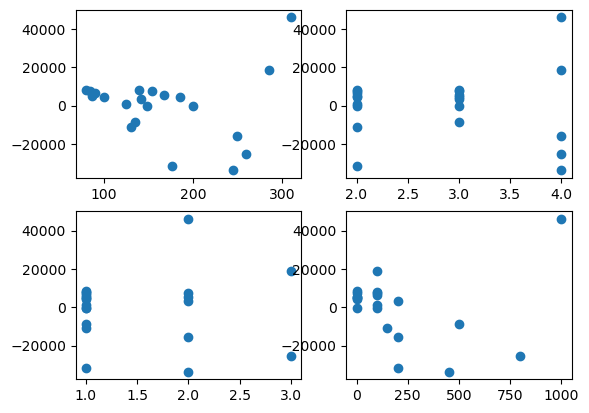

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.scatter(X['SquareMeterHouse'], residuals)
ax2.scatter(X['BedRooms'], residuals)
ax3.scatter(X['BathRooms'], residuals)
ax4.scatter(X['SquareMeterGarden'], residuals)
plt.show()


The last model diagnostic that we’re going to look at is whether there is a correlation inside the observations of the error term. If this happens, you definitely violate assumption 1: the observations are not drawn randomly.


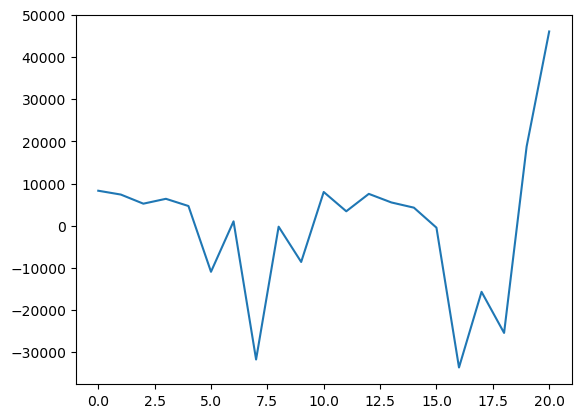

In [21]:
plt.plot(residuals.index, residuals)

In [25]:
print(result.params)
print(result.tvalues)

const                23673.288951
SquareMeterHouse       581.228663
BedRooms              7903.113201
BathRooms             4726.931719
SquareMeterGarden       21.031566
dtype: float64
const                1.272783
SquareMeterHouse     4.022985
BedRooms             0.590659
BathRooms            0.433294
SquareMeterGarden    0.986398
dtype: float64


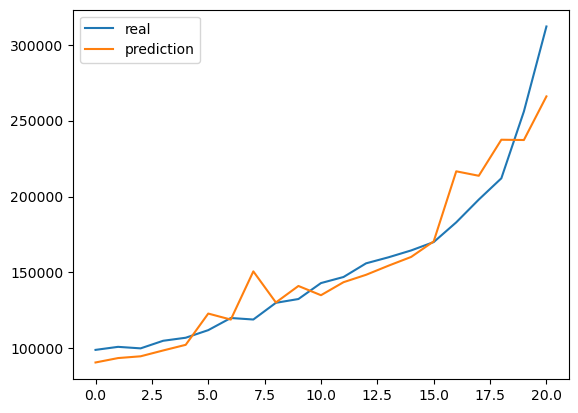

In [36]:
# for obs, pred in zip(y.to_numpy(), result.predict()):
#     print(obs, pred)
plt.figure()
plt.plot(y.to_numpy(), label="real")
plt.plot(result.predict(), label="prediction")
plt.legend()
plt.show()